In [2]:
import numpy as np
import tensorflow as tf
import time
from datetime import timedelta
from sklearn.metrics import confusion_matrix
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tf.__version__

'1.5.0'

In [4]:
filter_size1 = 5 
num_filters1 = 16

filter_size2 = 5
num_filters2 = 36

fc_size = 128

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [6]:
print("Size of:")
print(f"Training-set: {len(data.train.labels)}")
print(f"Test-dat: {len(data.test.labels)}")
print(f"Validation-set: {len(data.validation.labels)}")


Size of:
Training-set: 55000
Test-dat: 10000
Validation-set: 5000


In [7]:
data.test.cls = np.argmax(data.test.labels, axis=1)

In [8]:
img_size = 28

img_size_flat = img_size * img_size

img_shape = (img_size, img_size)

num_channels = 1

num_classes = 10

In [9]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        if cls_pred is None:
            xlabel = f"True: {cls_true[i]}"
        else:
            xlabel = f"True: {cls_true[i]}, Pred: {cls_pred[i]}"
        
        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()    

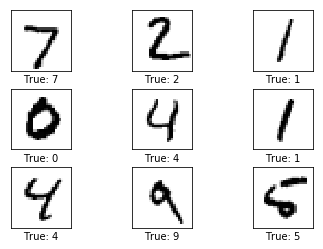

In [10]:
images = data.test.images[0:9]

cls_true = data.test.cls[0:9]

plot_images(images=images, cls_true=cls_true)

In [11]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [12]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [13]:
def new_conv_layer(input,
                  num_input_channels,
                  filter_size,
                  num_filters,
                  use_pooling=True):
    
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    
    weights = new_weights(shape=shape)
    
    biases = new_biases(length=num_filters)
    
    layer = tf.nn.conv2d(input=input,
                        filter=weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    
    layer += biases
    
    if use_pooling:
        
        layer = tf.nn.max_pool(value=layer,
                              ksize=[1, 2, 2, 1],
                              strides=[1, 2, 2, 1],
                              padding='SAME')
        
    layer = tf.nn.relu(layer)
        
    return layer, weights

In [14]:
def flatten_layer(layer):
    
    layer_shape = layer.get_shape()
    
    num_features = layer_shape[1:4].num_elements()
    
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    return layer_flat, num_features

In [15]:
def new_fc_layer(input,
                num_inputs,
                num_outputs,
                use_relu=True):
    
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    
    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
        
    return layer

## Placeholders

In [16]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

## Conv 1

In [17]:
layer_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                      num_input_channels=num_channels,
                                      filter_size=filter_size1,
                                       num_filters=num_filters1,
                                      use_pooling=True)

In [18]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

## Conv 2

In [19]:
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,
                                           num_input_channels=num_filters1,
                                           filter_size=filter_size2,
                                           num_filters=num_filters2,
                                           use_pooling=True)


In [20]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

In [21]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [22]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [23]:
num_features

1764

In [24]:
layer_fc1 = new_fc_layer(input=layer_flat,
                        num_inputs=num_features,
                        num_outputs=fc_size,
                        use_relu=True)

In [25]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [26]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                        num_inputs=fc_size,
                        num_outputs=num_classes,
                        use_relu=False)

In [27]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

In [28]:
y_pred = tf.nn.softmax(layer_fc2)

y_pred_cls = tf.argmax(y_pred, axis=1)

In [29]:
y_pred_cls

<tf.Tensor 'ArgMax_1:0' shape=(?,) dtype=int64>

In [30]:
y_true_cls

<tf.Tensor 'ArgMax:0' shape=(?,) dtype=int64>

In [28]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                       labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [29]:
cost = tf.reduce_mean(cross_entropy)

In [30]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [31]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [32]:
session = tf.Session()

In [33]:
session.run(tf.global_variables_initializer())

In [34]:
train_batch_size = 64

In [35]:
total_iterations = 0

def optimize(num_iterations):
    global total_iterations
    
    start_time = time.time()
    
    for i in range(total_iterations,
                  total_iterations + num_iterations):
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        print(f"SHAPE: {x_batch.shape}")
        
        feed_dict_train = {x: x_batch,
                          y_true: y_true_batch}
        
        session.run(optimizer, feed_dict=feed_dict_train)
        
        if i % 100 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            
            print(f"Optimization Iteration: {i+1}, Training Accuracy: {acc} %")
        
    total_iterations += num_iterations
        
    end_time = time.time()
        
    time_dif = end_time - start_time
        
    print(f"Time usage: {timedelta(seconds=int(round(time_dif)))}")
        

In [36]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    
    images = data.test.images[incorrect]
    
    cls_pred = cls.pred[incorrect]
    
    cls_true = data.test.cls[incorrect]
    
    plot_images(images=images[0:9],
               cls_true=cls_true[0:9],
               cls_pred=cls_pred[0:9])

In [37]:
def plot_confusion_matrix(cls_pred):
    cls_true = data.test.cls
    
    cm = confusion_matrix(y_true=cls_true,
                         y_pred=cls_pred)
    
    print(cm)
    
    plt.matshow(cm)
    
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()
    
    
    

In [43]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
#     acc = float(correct_sum) / num_test
    acc = float(correct_sum) / len(correct)
    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Test

In [44]:
print_test_accuracy()

Accuracy on Test-Set: 65.1% (6512 / 10000)


In [40]:
optimize(num_iterations=1)

SHAPE: (64, 784)
Optimization Iteration: 1, Training Accuracy: 0.078125 %
Time usage: 0:00:01


In [41]:
print_test_accuracy()

Accuracy on Test-Set: 10.4% (1040 / 10000)


In [42]:
optimize(num_iterations=99) # We already performed 1 iteration above.

SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 784)
SHAPE: (64, 78

KeyboardInterrupt: 

In [ ]:
print_test_accuracy()

In [ ]:
optimize(num_iterations=900)

In [ ]:
print_test_accuracy()

In [ ]:
optimize(num_iterations=9000)

In [ ]:
print_test_accuracy()

In [ ]:
optimize(num_iterations=100)

In [ ]:
print_test_accuracy()

In [ ]:
optimize(num_iterations=100)

In [ ]:
print_test_accuracy()

In [ ]:
optimize(num_iterations=1000)

In [ ]:
print_test_accuracy()

In [ ]:
optimize(num_iterations=100)

In [ ]:
print_test_accuracy()

In [ ]:
test = 5
def printTest():
    print(test)

In [ ]:
printTest()